In [1]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from preprocessing import correct_skew, select_text_area, binarize_image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from fontClassifier import FontDataset

In [2]:
# Define your preprocessing function
def preprocess_data(img):
    img = binarize_image(img)
    img, _ = correct_skew(img)
    img = select_text_area(img)
    # Ensure the output is a PIL Image
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    return img

# Define transformations for data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((32, 128)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((32, 128)),
    transforms.ToTensor()
])


In [3]:
# Define dataset path
dataset_path = "Dataset"

# Load the dataset without any transforms initially
original_dataset = FontDataset(root_dir=dataset_path, preprocess_func=preprocess_data)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(original_dataset))
test_size = len(original_dataset) - train_size
train_indices, test_indices = random_split(range(len(original_dataset)), [train_size, test_size])

# Create subsets with different transforms
train_dataset = FontDataset(root_dir=dataset_path, preprocess_func=preprocess_data, transform=train_transforms)
test_dataset = FontDataset(root_dir=dataset_path, preprocess_func=preprocess_data, transform=test_transforms)

# Subset datasets
train_dataset.data = [original_dataset.data[i] for i in train_indices.indices]
train_dataset.labels = [original_dataset.labels[i] for i in train_indices.indices]
test_dataset.data = [original_dataset.data[i] for i in test_indices.indices]
test_dataset.labels = [original_dataset.labels[i] for i in test_indices.indices]

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
import matplotlib.pyplot as plt
import torch

def visualize_data(loader, classes, num_images=5):
    """
    Visualize a few images and their corresponding labels from a DataLoader.

    Args:
    - loader (torch.utils.data.DataLoader): DataLoader to visualize.
    - classes (list): List of class names.
    - num_images (int): Number of images to visualize.
    """
    # Get a batch of data
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Create a figure for visualization
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()  # Convert from CHW to HWC and NumPy array
        label = classes[labels[i].item()]
        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


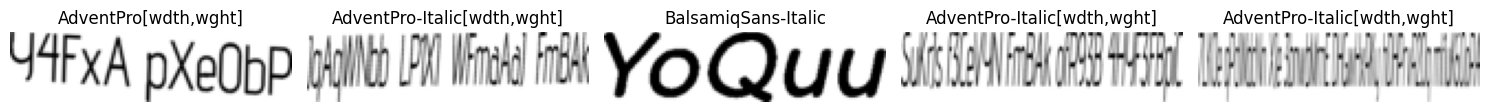

In [10]:
# Visualize training data
visualize_data(train_loader, train_dataset.classes)


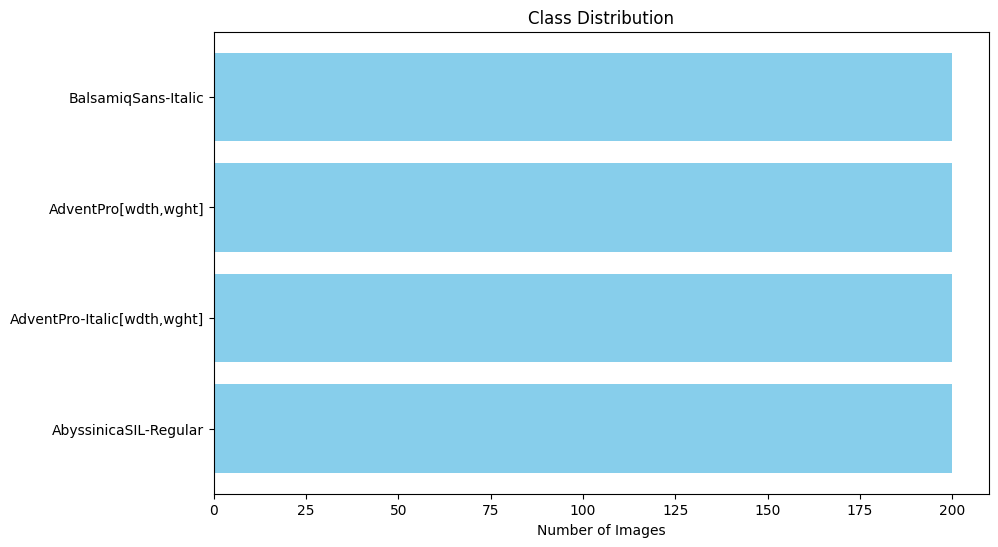

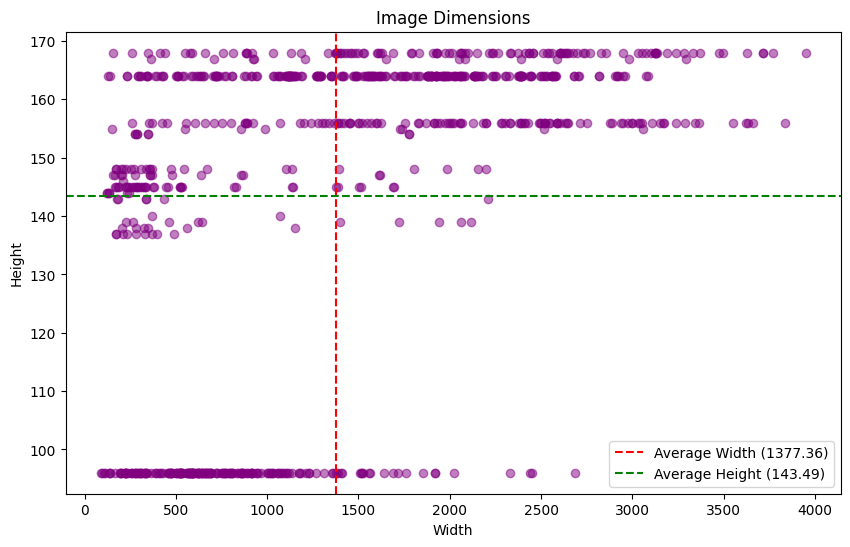

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter
import torchvision.transforms as transforms
from fontClassifier import FontDataset
from torchvision import datasets

def get_dataset_statistics(root_dir):
    # Initialize lists to store image dimensions and class labels
    image_dims = []
    class_counts = Counter()

    # Iterate through the dataset folder to get statistics
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_file)
                    # Get image dimensions
                    with Image.open(img_path) as img:
                        width, height = img.size
                        image_dims.append((width, height))
                    # Count class occurrences
                    class_counts[class_name] += 1

    # Calculate the average image dimensions
    avg_width = np.mean([dim[0] for dim in image_dims])
    avg_height = np.mean([dim[1] for dim in image_dims])

    return class_counts, image_dims, avg_width, avg_height


def visualize_class_distribution(class_counts):
    # Plot the class distribution
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.barh(classes, counts, color='skyblue')
    plt.xlabel('Number of Images')
    plt.title('Class Distribution')
    plt.show()


def visualize_image_dimensions(image_dims, avg_width, avg_height):
    # Plot the image dimensions
    widths = [dim[0] for dim in image_dims]
    heights = [dim[1] for dim in image_dims]

    plt.figure(figsize=(10, 6))
    plt.scatter(widths, heights, alpha=0.5, color='purple')
    plt.axvline(avg_width, color='red', linestyle='--', label=f'Average Width ({avg_width:.2f})')
    plt.axhline(avg_height, color='green', linestyle='--', label=f'Average Height ({avg_height:.2f})')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Image Dimensions')
    plt.legend()
    plt.show()

# Example of how to use the functions
dataset_path = "Dataset"  # Replace with your dataset path

# Get statistics of the dataset
class_counts, image_dims, avg_width, avg_height = get_dataset_statistics(dataset_path)

# Visualize the class distribution
visualize_class_distribution(class_counts)

# Visualize the image dimensions
visualize_image_dimensions(image_dims, avg_width, avg_height)